# Imports

In [2]:
import os
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Drone_Recog/")

Mounted at /content/gdrive


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical, image_dataset_from_directory
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2


In [4]:
h, w = 240, 360
frame_seq = 25
epochs = 500
vid_path = 'datasets/Videos'
img_path = 'datasets/Images'

class_names = os.listdir(vid_path)
num_class = len(class_names)

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Not connected to a GPU
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Plot

In [ ]:
def plot_graph(training_history, metric1, metric2, plot_name):
    """
    Function to plot and show graph of accuracy and loss
    :param training_history: record of training and validation (acc/loss)
    :param metric1: first metric
    :param metric2: second metric
    :param plot_name: name of plot
    """

    # Get metric values using metric names as identifiers.
    metric_1 = training_history.history[metric1]
    metric_2 = training_history.history[metric2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_1))

    # Plotting
    plt.plot(epochs, metric_1, 'blue', label=metric1)
    plt.plot(epochs, metric_2, 'red', label=metric2)

    # Add title
    plt.title(str(plot_name))

    # Legends
    plt.legend()
    plt.show()

# Prepare Dataset

In [1]:
def get_frames(path):
    """
    Function extracts frames of video after it is resize and normalized
    in the form of a list.
    :param path: path of video
    :return: list of frames of every video
    """

    frame_list = []

    # set capture object and count frames
    vid_reader = cv2.VideoCapture(path)
    frame_count = int(vid_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(int(frame_count / frame_seq), 1)

    # extracting frames
    for i in range(frame_seq):
        # skip a couple of frames (don't need everything)
        vid_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_skip)
        success, frame = vid_reader.read()
        # if no more frames, finish
        if not success:
            break
        resized_frame = cv2.resize(frame, (w, h))
        frame_list.append(resized_frame)
    vid_reader.release()  # release object

    return frame_list

In [6]:
feature = []
labels = []

for idx, class_name in enumerate(class_names):
    print(f'Extracting Data from: {class_name}')  # show progress
    files = os.listdir(os.path.join(vid_path, class_name))
    for name in files:
        print(f'Extracting Data from: {name}')
        path = os.path.join(vid_path, class_name, name)
        frames = get_frames(path)
        if len(frames) == frame_seq:
            feature.append(frames)
            labels.append(idx)

Extracting Data from: clapping
Extracting Data from: S3_clapping_HD.mp4
Extracting Data from: S4_clapping_HD.mp4
Extracting Data from: S5_clapping_HD.mp4
Extracting Data from: S6_clapping_HD.mp4
Extracting Data from: S7_clapping_HD.mp4
Extracting Data from: S8_clapping_HD.mp4
Extracting Data from: S9_clapping_HD.mp4
Extracting Data from: S10_clapping_HD.mp4
Extracting Data from: S1_clapping_HD.mp4
Extracting Data from: S2_clapping_HD.mp4
Extracting Data from: waving_hands
Extracting Data from: S1_wavingHands_HD.mp4
Extracting Data from: S3_wavingHands_HD.mp4
Extracting Data from: S4_wavingHands_HD.mp4
Extracting Data from: S5_wavingHands_HD.mp4
Extracting Data from: S6_wavingHands_HD.mp4
Extracting Data from: S7_wavingHands_HD.mp4
Extracting Data from: S8_wavingHands_HD.mp4
Extracting Data from: S9_wavingHands_HD.mp4
Extracting Data from: S10_wavingHands_HD.mp4
Extracting Data from: S2_wavingHands_HD.mp4
Extracting Data from: stabbing
Extracting Data from: S1_stabbing_toRight_HD.mp4
Ex

In [9]:
features = np.asarray(feature)
labels = np.array(labels)

print(features.shape)
print(labels.shape)

(40, 25, 240, 360, 3)
(40,)


In [10]:
if not os.path.exists('image_array'):
    os.makedirs('image_array')
    print("Created new directory 'image_array'")
np.save(f'image_array/{h}x{w}_features_test_25', features)
np.save(f'image_array/{h}x{w}_labels_test_25', labels)

# Model

Time Distributed

In [ ]:
# Time-Distributed CNN
def build_CNN():
    In = Input(shape=(frame_seq, h, w, 3), name='CNN_Input')
    x = TimeDistributed(Conv2D(32, (3, 3), strides = (2, 2), padding='same', activation='relu'), name='conv_1')(In)
    x = TimeDistributed(MaxPooling2D(4))(x)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'), name='conv_2a')(x)
    x = TimeDistributed(MaxPooling2D(2))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_3a')(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_3b')(x)
    x = TimeDistributed(MaxPooling2D(2))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_4a')(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_4b')(x)
    x = TimeDistributed(MaxPooling2D(2))(x)

    return Model(In, x, name = 'CNN')


In [ ]:
# input
LRCN_in = Input(shape=(frame_seq, h, w, 3), name = 'CNN_Input')

# build cnn
Convo = build_CNN()

# passing input through CNN
cnn = Convo(LRCN_in)

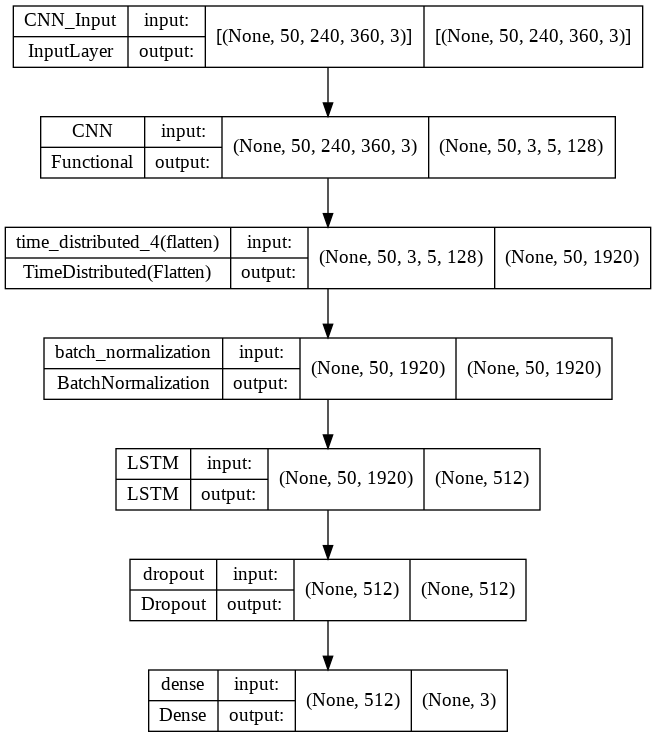

In [ ]:
# LSTM network
x = TimeDistributed(Flatten())(cnn)
x = BatchNormalization(name = 'batch_normalization')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
x = Dropout(0.5, name = 'dropout')(x)
LRCN_out = Dense(num_class, activation = 'softmax')(x)

# build model
tLRCN_model = Model(LRCN_in, LRCN_out, name = 'LRCN_Model')
plot_model(tLRCN_model, show_shapes = True)

3D CNN

In [ ]:
# 3D CNN
def build_3DConv():
    In = Input(shape=(frame_seq, h, w, 3), name='3DCNN_Input')
    x = Conv3D(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name='conv3d_1')(In)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool_1')(x)

    x = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu', name='conv3d_2')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_2')(x)

    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_3')(x)
    
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_4')(x)
    
    return Model(In, x, name = '3DConv')

In [ ]:
# inputs
LRCN_in = Input(shape=(frame_seq, h, w, 3), name = '3DCNN_Input')

# build 3d-cnn
Conv3d = build_3DConv()

# passing input through 3d CNN
cnn_3d = Conv3d(LRCN_in)

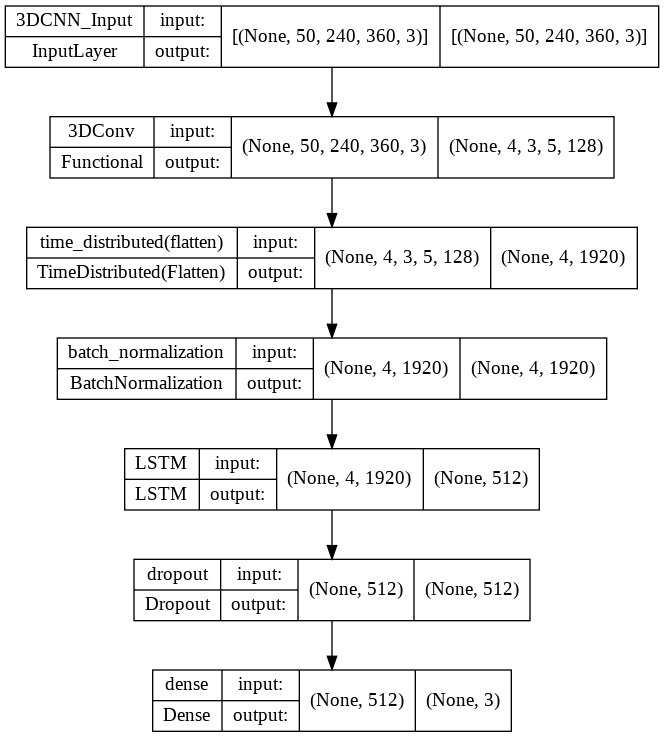

In [ ]:
# LSTM network
x = TimeDistributed(Flatten())(cnn_3d)
x = BatchNormalization(name = 'batch_normalization')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
x = Dropout(0.5, name = 'dropout')(x)
LRCN_out = Dense(num_class, activation = 'softmax')(x)

# build model
LRCN3d_model = Model(LRCN_in, LRCN_out, name = 'LRCN_Model')
plot_model(LRCN3d_model, show_shapes = True)

# Training

Get dataset

In [ ]:
# Get Dataset
features = np.load(f'image_array/{h}x{w}_features.npy')
labels = np.load(f'image_array/{h}x{w}_labels.npy')

features = features / 255.0
labels = to_categorical(labels, num_classes=num_class)

print(features.shape)
print(labels.shape)

(40, 50, 240, 360, 3)
(40, 3)


Train

In [ ]:
# compiling model
LRCN3d_model.compile(loss = 'categorical_crossentropy', # measures model accuracy
              optimizer = optimizers.Adam(learning_rate = 0.00001),
              metrics = ['accuracy'])

In [ ]:
# Show model summary
LRCN3d_model.summary()

Model: "LRCN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3DCNN_Input (InputLayer)    [(None, 50, 240, 360, 3)  0         
                             ]                                   
                                                                 
 3DConv (Functional)         (None, 4, 3, 5, 128)      1606784   
                                                                 
 time_distributed (TimeDistr  (None, 4, 1920)          0         
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 1920)          7680      
 ormalization)                                                   
                                                                 
 LSTM (LSTM)                 (None, 512)               4982784   
                                                        

In [ ]:
# Run Training
LRCN3d_history = LRCN3d_model.fit(features, labels,
                    validation_split=0.3,
                    batch_size = 4,
                    epochs=epochs)

Epoch 1/500
7/7 [==============================] - 3s 477ms/step - loss: 1.0925 - accuracy: 0.3929 - val_loss: 1.0930 - val_accuracy: 1.0000
Epoch 2/500
7/7 [==============================] - 2s 292ms/step - loss: 1.0879 - accuracy: 0.5714 - val_loss: 1.0931 - val_accuracy: 1.0000
Epoch 3/500
7/7 [==============================] - 2s 283ms/step - loss: 1.0839 - accuracy: 0.3929 - val_loss: 1.0942 - val_accuracy: 0.9167
Epoch 4/500
7/7 [==============================] - 2s 290ms/step - loss: 1.0712 - accuracy: 0.5000 - val_loss: 1.0954 - val_accuracy: 0.6667
Epoch 5/500
7/7 [==============================] - 2s 287ms/step - loss: 1.0806 - accuracy: 0.4643 - val_loss: 1.0954 - val_accuracy: 0.9167
Epoch 6/500
7/7 [==============================] - 2s 292ms/step - loss: 1.0821 - accuracy: 0.5000 - val_loss: 1.0946 - val_accuracy: 1.0000
Epoch 7/500
7/7 [==============================] - 2s 293ms/step - loss: 1.0716 - accuracy: 0.3929 - val_loss: 1.0942 - val_accuracy: 1.0000
Epoch 8/500
7

In [ ]:
# split datasets for testing
X_train, X_test, Y_train, Y_test = train_test_split(
    features, labels, test_size=0.4, shuffle=True, random_state=123)
# Evaluate Accuracy
test_loss, test_acc = LRCN3d_model.evaluate(X_test, Y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

1/1 - 1s - loss: 0.4907 - accuracy: 0.8750 - 1s/epoch - 1s/step
Test Accuracy: 0.875


INFO:tensorflow:Assets written to: model results/LRCN_model__Loss_0.49073150753974915__Acc_0.875/assets


INFO:tensorflow:Assets written to: model results/LRCN_model__Loss_0.49073150753974915__Acc_0.875/assets


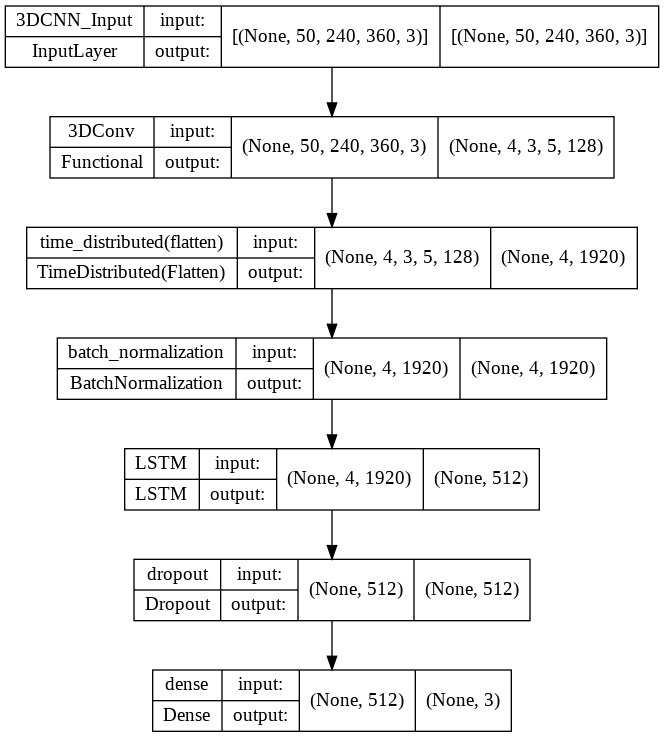

In [ ]:
# saving model
file_name = f'model results/LRCN_model__Loss_{test_loss}__Acc_{test_acc}'
LRCN3d_model.save(file_name)
# plot model
plot_model(LRCN3d_model, to_file=f'model results/LRCN_model__Loss_{test_loss}__Acc_{test_acc}/LRCN_model.png',
            show_shapes = True)

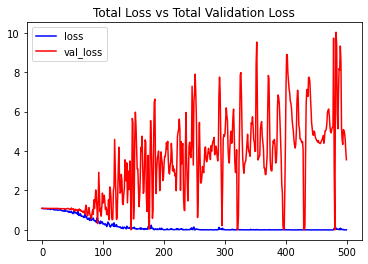

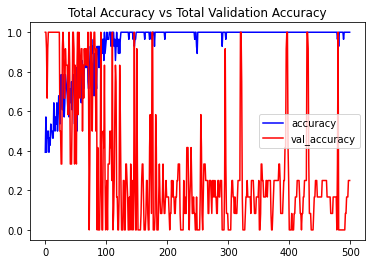

In [ ]:
# plotting loss and accuracy
plot_graph(LRCN3d_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_graph(LRCN3d_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')